In [1]:
import spacy
import timeit
import math
import pandas as pd
import matplotlib.pyplot as plt
from os import path
from collections import Counter
from lxml import etree
from glob import glob
from unicodedata import normalize
import unidecode
import seaborn as sns 

In [2]:
nlp = spacy.load('fr_core_news_lg')

In [3]:
nlp.max_length = 2000000

In [44]:
coef_fabula = pd.read_csv(r'results_svm/coefs_1000_fabula.csv', index_col='Unnamed: 0')

In [43]:
coef_fabula = pd.read_csv(r'results_svm/coefs_3000_fabula.csv', index_col='Unnamed: 0')

In [6]:
coef_fabula.sort_values(by = 'coefs', inplace=True)

In [7]:
len(coef_fabula)

3000

In [8]:
coef_canon_df = coef_fabula[:500]

In [9]:
coef_non_canon_df = coef_fabula[2500:]

In [10]:
def clean_text(txt):
    txt_res = normalize("NFKD", txt.replace('\xa0', ' '))
    txt_res = txt_res.replace('\\xa0', '')
    return txt_res

In [11]:
def get_chunks_scores(path, df_coef, n):
    score = 0
    list_lemma = []
    str_base = ' '
    
    with open(path, encoding="utf8") as file:
        txt_brut = file.readlines()
        txt_str = str_base.join(txt_brut)
        txt_cleaned = clean_text(txt_str.lower())
    docs = nlp(txt_cleaned)
    for token in docs:
        list_lemma.append(token.lemma_)
    list_chunks = chunkise(list_lemma, n)
    return compute_score(list_chunks, df_coef)

In [15]:
def chunkise(list_token, n):
    list_chunks = []
    for i in range(0, len(list_token)-n, n-100):
        list_chunks.append(list_token[i:i+n])
    return list_chunks

In [16]:
def compute_score(list_chunks, df_coef):
    list_scores = []
    for chunk in list_chunks:
        score = 0
        for lemma in chunk:
            if lemma in list(df_coef.index):
                temp_score = coef_fabula.loc[coef_fabula.index == lemma]
                score += temp_score.values[0][0]
        list_scores.append(score)
    return list_scores

In [17]:
def signal_canon(path_name, n_token_per_chunk, df_coef):
    
    df_main = pd.DataFrame()

    for doc in glob(path_name):
        
        doc_name = path.splitext(path.basename(doc))[0]
        print(doc_name)
        
        list_scores = get_chunks_scores(doc, df_coef, n_token_per_chunk)
        print(pd.Series(list_scores).mean())
        df_main[doc_name] = pd.Series(list_scores)
    
    return df_main.fillna(0)


In [18]:
n_token_per_chunk = 500

In [19]:
path_name = r'corpus_test/*.txt'

In [41]:
df_scores = signal_canon(path_name, n_token_per_chunk, coef_fabula)

1873_Pressense-Elise-de_Un-petit-monde-d-enfants
-2.07668728984201
1869_Flaubert-Gustave_L-Education-sentimentale
2.7227931597347848


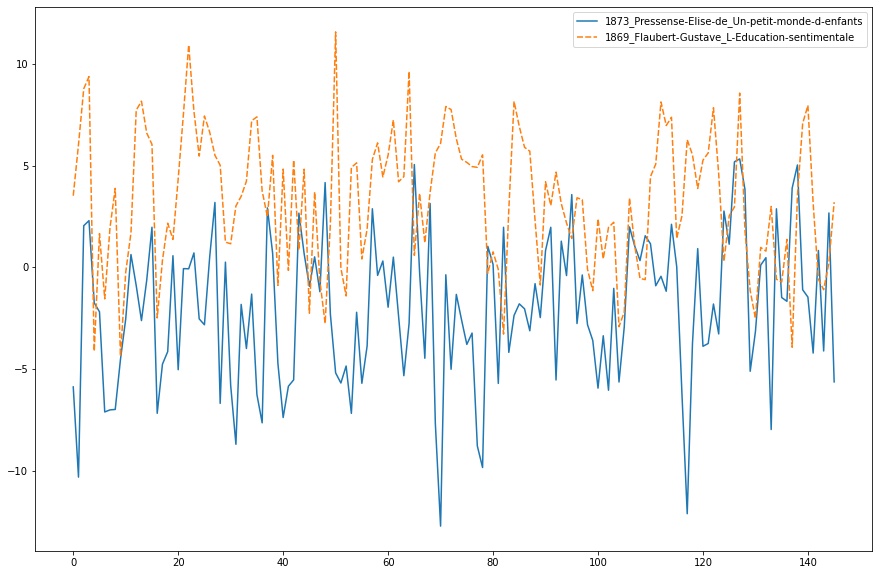

In [42]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=df_scores)

In [39]:
df_scores.drop(["1873_Pressense-Elise-de_Un-petit-monde-d-enfants"], axis=1, inplace=True)

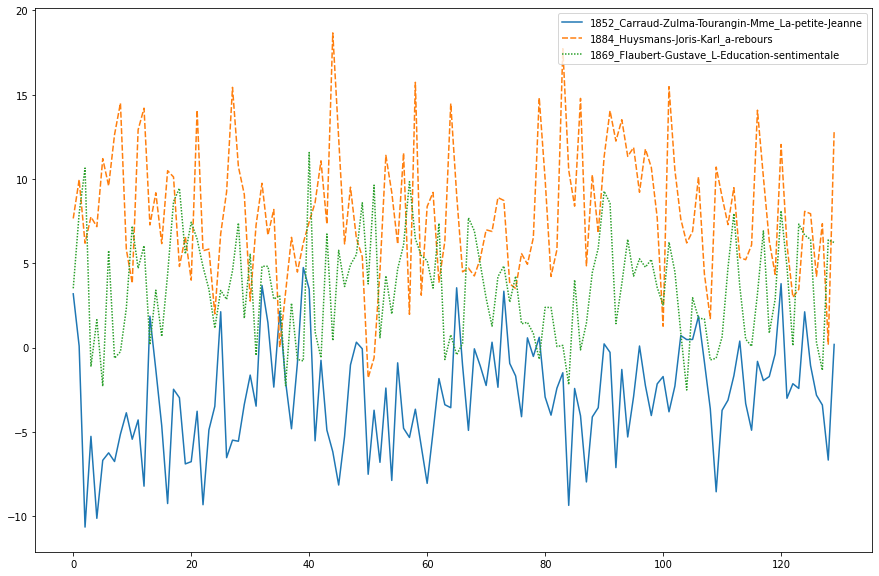

In [61]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=df_scores)

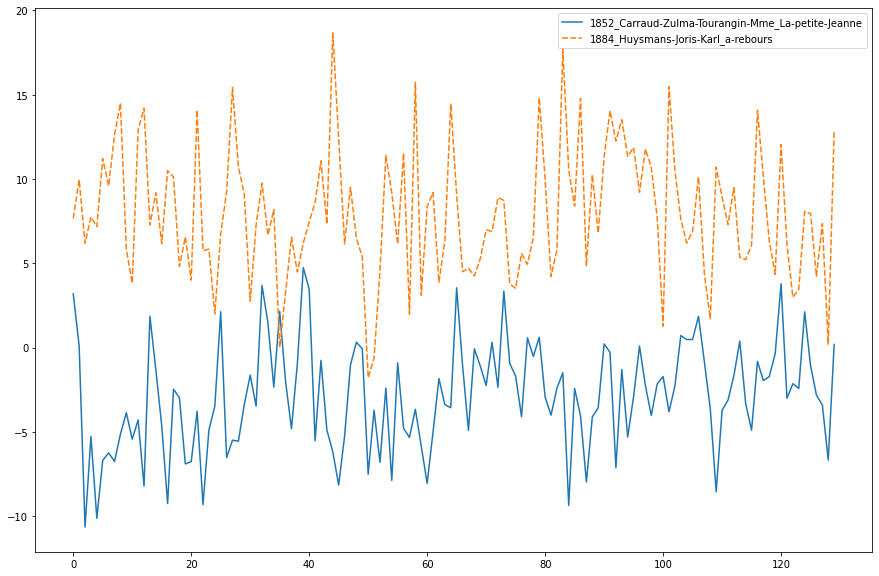

In [77]:
plt.figure(figsize=(15,10))
ax = sns.lineplot(data=df_scores)

In [45]:
df_scores['1869_Flaubert-Gustave_L-Education-sentimentale'].max()

11.570494084220691

In [46]:
extrait_max = df_scores[df_scores['1869_Flaubert-Gustave_L-Education-sentimentale'] == 11.570494084220691]

In [47]:
extrait_max

,1873_Pressense-Elise-de_Un-petit-monde-d-enfants,1869_Flaubert-Gustave_L-Education-sentimentale
50,-5.188699,11.570494


In [ ]:
# passage 51

In [51]:
df_scores['1873_Pressense-Elise-de_Un-petit-monde-d-enfants'].min()

-12.718133165681666

In [52]:
extrait_min = df_scores[df_scores['1873_Pressense-Elise-de_Un-petit-monde-d-enfants'] == -12.718133165681666]

In [53]:
extrait_min

,1873_Pressense-Elise-de_Un-petit-monde-d-enfants,1869_Flaubert-Gustave_L-Education-sentimentale
70,-12.718133,6.090082


In [56]:
# passage 71

In [48]:
def get_chunk_n(path, n, passage_n):
    score = 0
    list_token = []
    str_base = ' '
    
    with open(path, encoding="utf8") as file:
        txt_brut = file.readlines()
        txt_str = str_base.join(txt_brut)
        txt_cleaned = clean_text(txt_str.lower())
    docs = nlp(txt_cleaned)
    for token in docs:
        list_token.append(token.text)
    list_chunks = chunkise(list_token, n)
    
    return str_base.join(list_chunks[passage_n])

In [49]:
path_name = r'corpus_test/1869_Flaubert-Gustave_L-Education-sentimentale.txt'

In [50]:
get_chunk_n(path_name, 500, 51)

'rocambole au - dessous de la religion comme poésie , et de la politique comme intérêt . vous n’ arriverez pas à son but , – oui , son but ! – qui est de nous causer une exaltation impersonnelle , avec de petites œuvres , malgré toutes vos finasseries d’ exécution . voilà les tableaux de bassolier , par exemple : c’ est joli , coquet , propret , et pas lourd ! ça peut se mettre dans la poche , se prendre en voyage ! les notaires achètent ça vingt mille francs ; il y a pour trois sous d’ idées ; mais , sans l’ idée , rien de grand ! sans grandeur , pas de beau ! l’ olympe est une montagne ! le plus crâne monument , ce sera toujours les pyramides . mieux vaut l’ exubérance que le goût , le désert qu’ un trottoir , et un sauvage qu’ un coiffeur ! frédéric , en écoutant ces choses , regardait mme arnoux . elles tombaient dans son esprit comme des métaux dans une fournaise , s’ ajoutaient à sa passion et faisaient de l’ amour.il était assis trois places au - dessous d’

In [54]:
path_name = r'corpus_test/1873_Pressense-Elise-de_Un-petit-monde-d-enfants.txt'

In [55]:
get_chunk_n(path_name, 500, 59)

'je suis seule pour suffire à tout et que je suis moins forte qu’ autrefois .   il ne répondit pas et la mère continua :   — oh ! mon pauvre enfant , si tu voulais m’ écouter et te donner de la peine pour apprendre à lire et à écrire ! ... tu es grand et fort ; l’ année prochaine tu entrerais en apprentissage et tu pourrais bientôt m’ aider . pense comme tu serais heureux quand tu m apporterais l’ argent que tu aurais gagné toi - même , et comme alors tout deviendrait facile .   maurice balançait ses pieds sans répondre et tenait sa tête baissée pour ne pas rencontrer le regard de sa mère . quelque chose lui disait qu’ il serait en effet bien heureux de gagner de l’ argent et de le lui donner , mais pour rien au monde il n’ aurait voulu lui faire le plaisir d’ en convenir . il ne voulait pas la regarder non plus , car il sentait que peut - être il lui serait plus difficile de résister au muet appel de ses yeux qu’ à ses paroles . il se leva pour quitter la chambre . 